In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

#Generate Synthetic Dataset

In [86]:
def generate_data(m, d, k):
    np.random.seed(123)
    A = np.random.randn(m, d)

    np.random.seed(42)
    X = np.random.randn(d, k)

    np.random.seed(1234)
    E = np.random.randn(m, k)

    return A, X, E

In [87]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)
#Calculate partial derivative
def gradient_JC(input, W, label, exp_AX, sum_exp, j, c):
    gradient = np.sum(input[:, j] * (exp_AX[:, c] / sum_exp))
    mask = (label == c)
    gradient -= np.sum(input[mask, j])
    return gradient

#Calculate Gradient
def gradient(input, W, label, exp_AX, sum_exp):
    gradients = np.zeros_like(W)
    for j in range(W.shape[0]):
        for c in range(W.shape[1]):
            gradients[j, c] = gradient_JC(input, W, label, exp_AX, sum_exp, j, c)
    return gradients

#Calculate objective function
def loss_function(AX, sum_exp, label):
    loss = np.sum(-np.log(softmax(AX)[np.arange(len(label)), label]))
    return loss

#Calculate Accuracy
def calculate_accuracy(input, W, label):
    AW = input @ W
    predictions = np.argmax(AW, axis=1)
    accuracy = np.mean(predictions == label)
    return accuracy

In [88]:
# Generate random data
A, X, E = generate_data(m=1000, d=1000, k=50)
# Generate labels for each class
B = np.argmax((A @ X) + E, axis=1)

##Computing Lipschitz Constant

In [ ]:
# Compute the spectral norm of A
singular_values = np.linalg.svd(A[:800,:], compute_uv=False)
spectral_norm_A = np.max(singular_values)

# Lipschitz constant for the gradient
L = spectral_norm_A ** 2

print("Spectral norm of A:", spectral_norm_A)
print("Lipschitz constant L:", L)

Spectral norm of A: 59.65528216907054
Lipschitz constant L: 3558.752690671425


##GD

In [90]:
# Set the step size using the Lipschitz constant
step_size = 1 / L
EPSILON = 1e-10
max_iter = 200

# Initialize W
W = np.ones((1000, 50))

losses_train_GD = []
losses_test_GD = []
accuracies_train_GD = [calculate_accuracy(A[800:,:], W, B[800:])]
accuracies_test_GD = [calculate_accuracy(A[:800,:], W, B[:800])]
cpu_times = [0]
start_time = time.time()

for n in range(max_iter):
    AW = A[:800,:] @ W
    exp_AW = np.exp(AW)
    sum_exp = exp_AW.sum(axis=1)

    U = gradient(A[:800,:], W, B[:800], exp_AW, sum_exp)
    W = W - (step_size * U)


    loss_train = loss_function(A[:800,:] @ W, np.exp(A[:800,:]@W).sum(axis=1), B[:800])
    losses_train_GD.append(loss_train)
    loss_test = loss_function(A[800:,:] @ W, np.exp(A[800:,:]@W).sum(axis=1), B[800:])
    losses_test_GD.append(loss_test)

    accuracy_train = calculate_accuracy(A[:800,:], W, B[:800])
    accuracies_train_GD.append(accuracy_train)
    accuracy_test = calculate_accuracy(A[800:,:], W, B[800:])
    accuracies_test_GD.append(accuracy_test)

    # Record elapsed time
    elapsed_time = time.time() - start_time
    cpu_times.append(elapsed_time)

    print(f"Iteration {n + 1}, Loss: {loss_train, loss_test}")

    if np.linalg.norm(U) < EPSILON:
        break

print("Optimized X:\n", W)


Iteration 1, Loss: (2893.3375668177723, 777.6289820821135)
Iteration 2, Loss: (2662.702143897628, 773.1702429986003)
Iteration 3, Loss: (2438.679168237197, 769.027980482522)
Iteration 4, Loss: (2222.4358401027466, 765.2017311199801)
Iteration 5, Loss: (2015.3169677680014, 761.6904844620823)
Iteration 6, Loss: (1818.780507471018, 758.4919992144808)
Iteration 7, Loss: (1634.2840058086967, 755.6019625532762)
Iteration 8, Loss: (1463.130566331693, 753.0131180648116)
Iteration 9, Loss: (1306.3041571452359, 750.714569761786)
Iteration 10, Loss: (1164.3381788771128, 748.6914905576792)
Iteration 11, Loss: (1037.2554745159355, 746.9253809749368)
Iteration 12, Loss: (924.5926698332602, 745.3948590140583)
Iteration 13, Loss: (825.4922717590914, 744.0767992025023)
Iteration 14, Loss: (738.8290228850162, 742.9475616820173)
Iteration 15, Loss: (663.3374257205061, 741.9840821952696)
Iteration 16, Loss: (597.7185922614881, 741.1646889832846)
Iteration 17, Loss: (540.7175980044465, 740.469613400975)
It

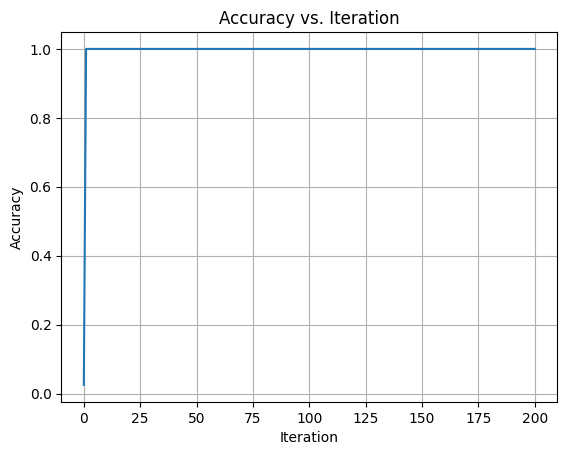

In [91]:
# Plot accuracy versus iteration
plt.plot(accuracies_train_GD)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iteration')
plt.grid(True)
plt.show()

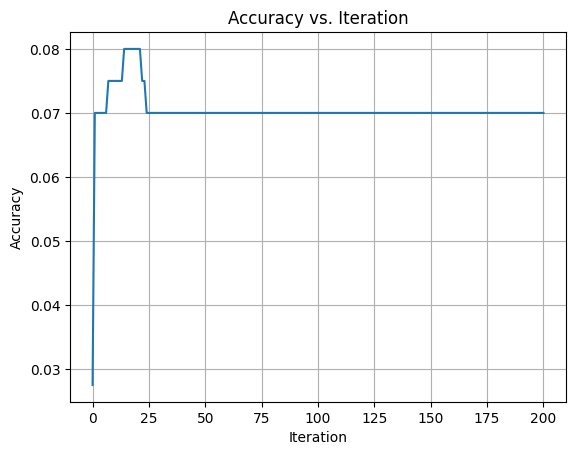

In [92]:
# Plot accuracy versus iteration
plt.plot(accuracies_test_GD)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iteration')
plt.grid(True)
plt.show()

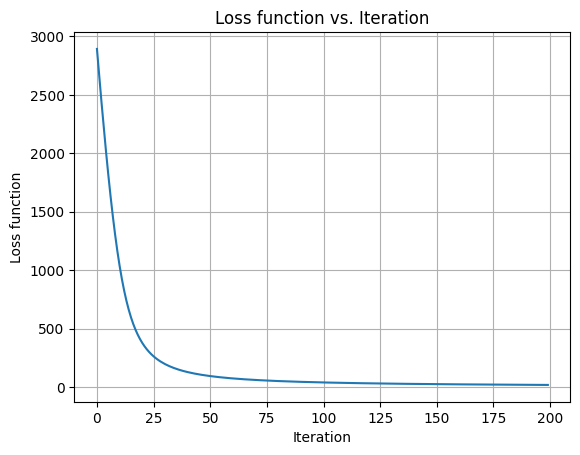

In [93]:
# Plot accuracy versus iteration
plt.plot(losses_train_GD)
plt.xlabel('Iteration')
plt.ylabel('Loss function')
plt.title('Loss function vs. Iteration')
plt.grid(True)
plt.show()

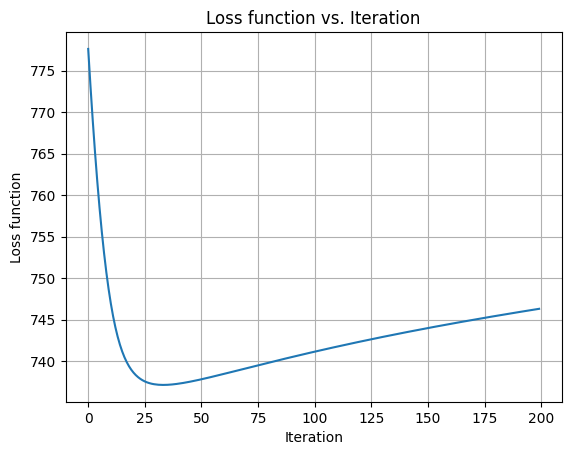

In [94]:
# Plot accuracy versus iteration
plt.plot(losses_test_GD)
plt.xlabel('Iteration')
plt.ylabel('Loss function')
plt.title('Loss function vs. Iteration')
plt.grid(True)
plt.show()

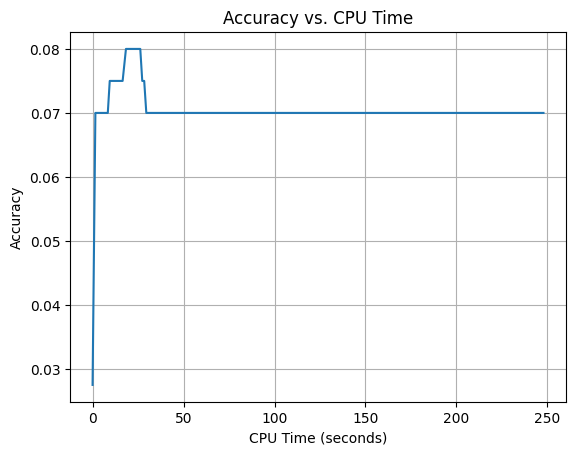

In [95]:
plt.plot(cpu_times, accuracies_test_GD)
plt.xlabel('CPU Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. CPU Time')
plt.grid(True)
plt.show()

##BCGD

In [96]:
# Initialize X
W = np.ones((1000, 50))

EPSILON = 1e-10
max_iter = 200


losses_train_BCGD = []
losses_test_BCGD = []
accuracies_train_BCGD = [calculate_accuracy(A[800:,:], W, B[800:])]
accuracies_test_BCGD = [calculate_accuracy(A[:800,:], W, B[:800])]
cpu_times = [0]
start_time = time.time()

for n in range(max_iter):
    AW = A[:800,:] @ W
    exp_AW = np.exp(AW)
    sum_exp = exp_AW.sum(axis=1)

    U = gradient(A[:800,:], W, B[:800], exp_AW, sum_exp)

    # Compute the gradient for each block (column)
    block_gradients = np.linalg.norm(U, axis=0)
    max_block_idx = np.argmax(block_gradients)

    # Update the selected block (column) using Lipschitz constant
    step_size = 1 / L
    W[:, max_block_idx] -= step_size * U[:, max_block_idx]

    # Compute the new loss
    loss_train = loss_function(A[:800,:] @ W, np.exp(A[:800,:]@W).sum(axis=1), B[:800])
    losses_train_BCGD.append(loss_train)
    loss_test = loss_function(A[800:,:] @ W, np.exp(A[800:,:]@W).sum(axis=1), B[800:])
    losses_test_BCGD.append(loss_test)

    accuracy_train = calculate_accuracy(A[:800,:], W, B[:800])
    accuracies_train_BCGD.append(accuracy_train)
    accuracy_test = calculate_accuracy(A[800:,:], W, B[800:])
    accuracies_test_BCGD.append(accuracy_test)

    # Record elapsed time
    elapsed_time = time.time() - start_time
    cpu_times.append(elapsed_time)

    print(f"Iteration {n + 1}, Loss: {loss_train, loss_test}")

    # Check for convergence
    if np.linalg.norm(U) < EPSILON:
        break

print("Optimized W:\n", W)

Iteration 1, Loss: (3122.239652687237, 782.1867563910156)
Iteration 2, Loss: (3115.0397286639427, 781.9805620104818)
Iteration 3, Loss: (3107.944039821283, 781.9603341983334)
Iteration 4, Loss: (3100.957279379602, 781.7660415865188)
Iteration 5, Loss: (3094.0279010145973, 781.7533180547772)
Iteration 6, Loss: (3087.226313256885, 781.5634053738396)
Iteration 7, Loss: (3080.4959904031975, 781.3813305960418)
Iteration 8, Loss: (3073.7608597882963, 781.3759342443939)
Iteration 9, Loss: (3067.0195932774145, 781.0285868216647)
Iteration 10, Loss: (3060.2880084596463, 780.7898250315866)
Iteration 11, Loss: (3053.6560546536643, 780.609685774866)
Iteration 12, Loss: (3047.0626437214687, 780.3932023777888)
Iteration 13, Loss: (3040.478077578494, 780.0567333181742)
Iteration 14, Loss: (3033.9018504327064, 779.8293131163807)
Iteration 15, Loss: (3027.3600499738004, 779.7787765164976)
Iteration 16, Loss: (3020.8563881334435, 779.7806284563113)
Iteration 17, Loss: (3014.434870888188, 779.61106242933

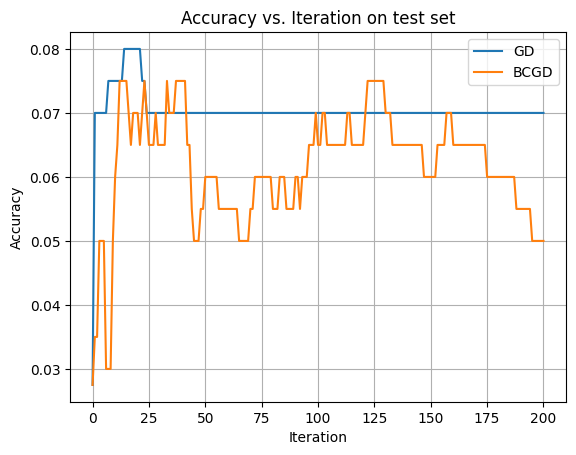

In [97]:
import matplotlib.pyplot as plt

# Plot both loss functions versus iteration on the same plot
plt.plot(accuracies_test_GD, label='GD')
plt.plot(accuracies_test_BCGD, label='BCGD')

# Set labels and title
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iteration on test set')

# Add grid
plt.grid(True)

# Add a legend to differentiate between the two curves
plt.legend()

# Show the plot
plt.show()


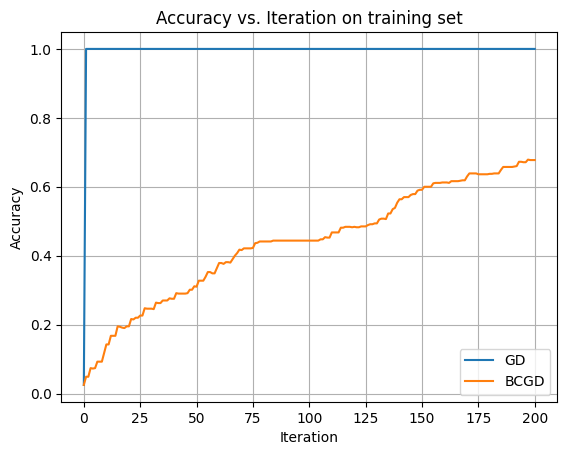

In [98]:
import matplotlib.pyplot as plt

# Plot both loss functions versus iteration on the same plot
plt.plot(accuracies_train_GD, label='GD')
plt.plot(accuracies_train_BCGD, label='BCGD')

# Set labels and title
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iteration on training set')

# Add grid
plt.grid(True)

# Add a legend to differentiate between the two curves
plt.legend()

# Show the plot
plt.show()


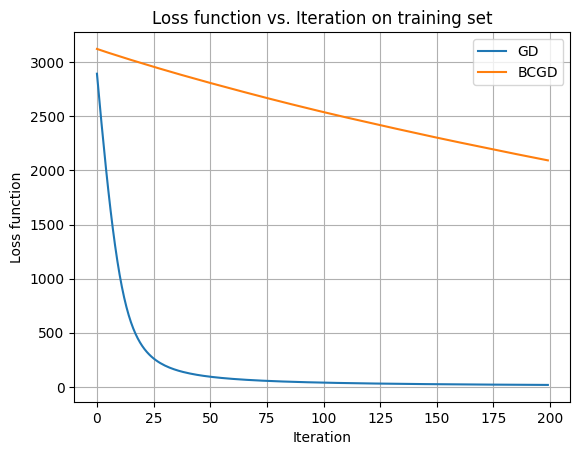

In [99]:

plt.plot(losses_train_GD, label='GD')
plt.plot(losses_train_BCGD, label='BCGD')

# Set labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss function')
plt.title('Loss function vs. Iteration on training set')

# Add grid
plt.grid(True)

# Add a legend to differentiate between the two curves
plt.legend()

# Show the plot
plt.show()


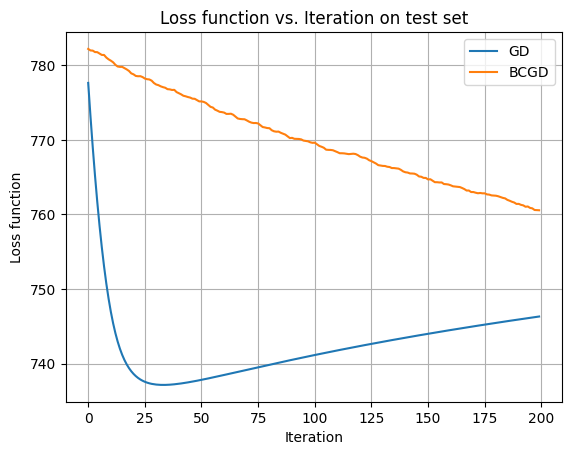

In [100]:
plt.plot(losses_test_GD, label='GD')
plt.plot(losses_test_BCGD, label='BCGD')

# Set labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss function')
plt.title('Loss function vs. Iteration on test set')

# Add grid
plt.grid(True)

# Add a legend to differentiate between the two curves
plt.legend()

# Show the plot
plt.show()

#Real Dataset

##Uploadin Data

In [ ]:
# Read CSV files
df = pd.read_csv("/content/sample_data/fashion-mnist_train.csv")
df_test = pd.read_csv("/content/sample_data/fashion-mnist_test.csv")

# Split data into features and labels
A_train = df.iloc[:, 1:785].values
B_train = df.iloc[:, 0].values
A_test = df_test.iloc[:, 1:785].values
B_test = df_test.iloc[:, 0].values

##Functions

In [ ]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Calculate partial derivative
def gradient_JC(input, W, label, exp_AX, sum_exp, j, c):
    gradient = np.sum(input[:, j] * (exp_AX[:, c] / sum_exp))
    mask = (label == c)
    gradient -= np.sum(input[mask, j])
    return gradient

# Calculate Gradient
def gradient(input, W, label, exp_AX, sum_exp):
    gradients = np.zeros_like(W)
    for j in range(W.shape[0]):
        for c in range(W.shape[1]):
            gradients[j, c] = gradient_JC(input, W, label, exp_AX, sum_exp, j, c)
    return gradients

# Calculate objective function
def loss_function(AX, sum_exp, label):
    loss = np.sum(-np.log(softmax(AX)[np.arange(len(label)), label]))
    return loss

# Calculate Accuracy
def calculate_accuracy(input, W, label):
    AW = input @ W
    predictions = np.argmax(AW, axis=1)
    accuracy = np.mean(predictions == label)
    return accuracy

## Computing Lipschitz Constant

In [101]:
# Compute the spectral norm of A
singular_values = np.linalg.svd(A_train, compute_uv=False)
spectral_norm_A = np.max(singular_values)

# Lipschitz constant for the gradient
L = spectral_norm_A ** 2

print("Spectral norm of A:", spectral_norm_A)
print("Lipschitz constant L:", L)

Spectral norm of A: 655838.2825723815
Lipschitz constant L: 430123852887.49097


##GD

In [53]:
# Set the step size using the Lipschitz constant
step_size = 1 / L
EPSILON = 1e-10
max_iter = 500

# Initialize W
W = np.zeros((784, 10))

losses_train_GD = []
losses_test_GD = []
accuracies_train_GD = [calculate_accuracy(A_train, W, B_train)]
accuracies_test_GD = [calculate_accuracy(A_test, W, B_test)]
cpu_times = [0]
start_time = time.time()

for n in range(max_iter):
    AW = A_train @ W
    exp_AW = np.exp(AW)
    sum_exp = exp_AW.sum(axis=1)

    U = gradient(A_train, W, B_train, exp_AW, sum_exp)
    W = W - (step_size * U)

    loss_train = loss_function(A_train @ W, np.exp(A_train @ W).sum(axis=1), B_train)
    losses_train_GD.append(loss_train)
    loss_test = loss_function(A_test @ W, np.exp(A_test @ W).sum(axis=1), B_test)
    losses_test_GD.append(loss_test)

    accuracy_train = calculate_accuracy(A_train, W, B_train)
    accuracies_train_GD.append(accuracy_train)
    accuracy_test = calculate_accuracy(A_test, W, B_test)
    accuracies_test_GD.append(accuracy_test)

    # Record elapsed time
    elapsed_time = time.time() - start_time
    cpu_times.append(elapsed_time)

    print(f"Iteration {n}, Loss: {loss_train, loss_test}")

    if np.linalg.norm(U) < EPSILON:
        break

print("Optimized W:\n", W)


Spectral norm of A: 655838.2825723815
Lipschitz constant L: 655838.2825723815
Iteration 0, Loss: (136709.060749958, 22783.75345953287)
Iteration 1, Loss: (135350.6785458079, 22556.36638456062)
Iteration 2, Loss: (134065.13900426848, 22341.206824927493)
Iteration 3, Loss: (132840.8552936022, 22136.33303086512)
Iteration 4, Loss: (131668.70287325623, 21940.215374876127)
Iteration 5, Loss: (130541.45129496028, 21751.641282186894)
Iteration 6, Loss: (129453.33839371787, 21569.643997337305)
Iteration 7, Loss: (128399.74694515803, 21393.448496408862)
Iteration 8, Loss: (127376.95661191837, 21222.4299929703)
Iteration 9, Loss: (126381.95217767978, 21056.081856953573)
Iteration 10, Loss: (125412.27444778782, 20893.990667475176)
Iteration 11, Loss: (124465.90383496358, 20735.81673028307)
Iteration 12, Loss: (123541.16918043904, 20581.278814356876)
Iteration 13, Loss: (122636.67616941343, 20430.142164779736)
Iteration 14, Loss: (121751.2510223021, 20282.20907016695)
Iteration 15, Loss: (120883.8

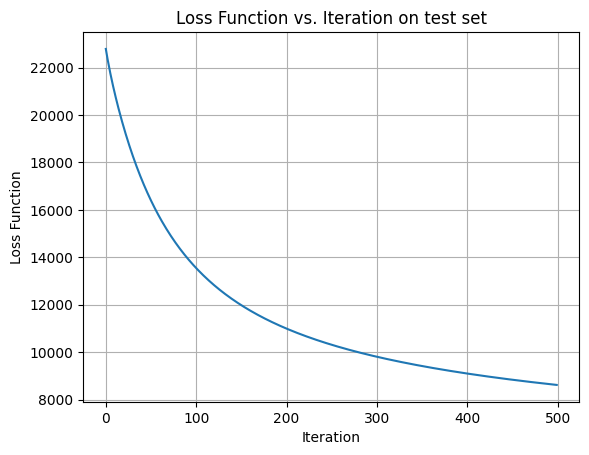

In [55]:
import matplotlib.pyplot as plt
plt.plot(losses_test_GD)

# Set labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss Function')
plt.title('Loss Function vs. Iteration on test set')
plt.grid(True)


# Show the plot
plt.show()

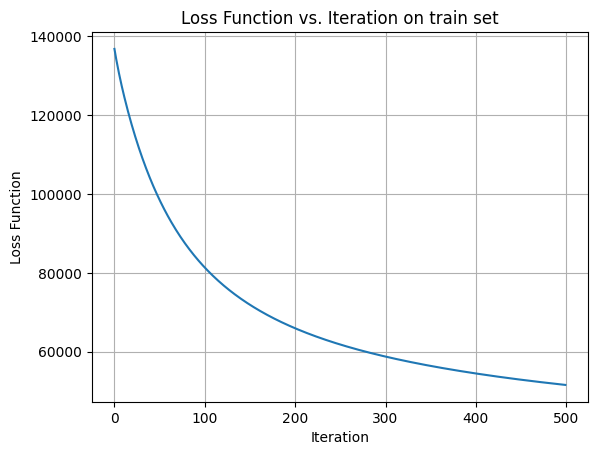

In [56]:
plt.plot(losses_train_GD)

# Set labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss Function')
plt.title('Loss Function vs. Iteration on train set')
plt.grid(True)


# Show the plot
plt.show()

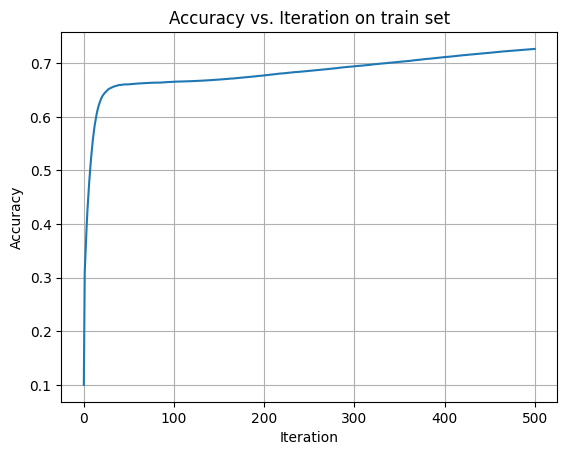

In [57]:
plt.plot(accuracies_train_GD)

# Set labels and title
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iteration on train set')
plt.grid(True)


# Show the plot
plt.show()

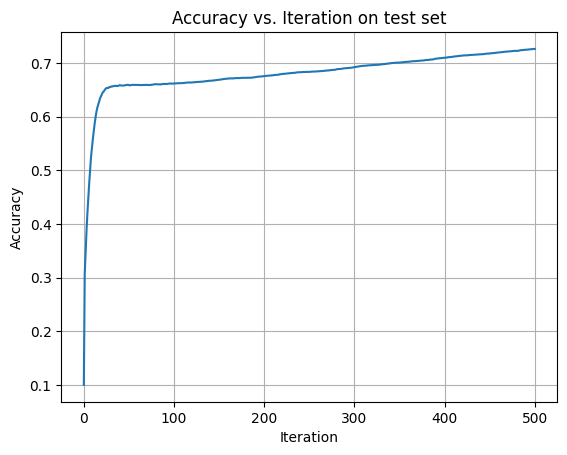

In [58]:
plt.plot(accuracies_test_GD)

# Set labels and title
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iteration on test set')
plt.grid(True)


# Show the plot
plt.show()

##BCGD

In [75]:
W = np.zeros((784, 10))
EPSILON = 1e-10
max_iter = 500

#Compute Lipschitz constants
singular_values = np.linalg.svd(A_train, compute_uv=False)
spectral_norm_A = np.max(singular_values)
L = spectral_norm_A ** 2

print("Spectral norm of A:", spectral_norm_A)
print("Lipschitz constant L:", L)

losses_train_BCGD = []
losses_test_BCGD = []
accuracies_train_BCGD = [calculate_accuracy(A_train, W, B_train)]
accuracies_test_BCGD = [calculate_accuracy(A_test, W, B_test)]
cpu_times = [0]
start_time = time.time()

for n in range(max_iter):
    AW = A_train @ W
    exp_AW = np.exp(AW)
    sum_exp = exp_AW.sum(axis=1)

    U = gradient(A_train, W, B_train, exp_AW, sum_exp)

    # Compute the gradient for each block (column)
    block_gradients = np.linalg.norm(U, axis=0)
    max_block_idx = np.argmax(block_gradients)

    # Update the selected block (column) using Lipschitz constant
    step_size = 1 / L
    W[:, max_block_idx] -= step_size * U[:, max_block_idx]

    # Compute the new loss
    loss_train = loss_function(A_train @ W, np.exp(A_train @ W).sum(axis=1), B_train)
    losses_train_BCGD.append(loss_train)
    loss_test = loss_function(A_test @ W, np.exp(A_test @ W).sum(axis=1), B_test)
    losses_test_BCGD.append(loss_test)

    accuracy_train = calculate_accuracy(A_train, W, B_train)
    accuracies_train_BCGD.append(accuracy_train)
    accuracy_test = calculate_accuracy(A_test, W, B_test)
    accuracies_test_BCGD.append(accuracy_test)

    # Record elapsed time
    elapsed_time = time.time() - start_time
    cpu_times.append(elapsed_time)

    print(f"Iteration {n}, Loss_BCGD_L: {loss_train, loss_test}")

    # Check for convergence
    if np.linalg.norm(U) < EPSILON:
        break

print("Optimized W:\n", W)

Spectral norm of A: 655838.2825723815
Lipschitz constant L: 430123852887.49097
Iteration 0, Loss_BCGD_L: (137921.68814096128, 22987.062456548956)
Iteration 1, Loss_BCGD_L: (137704.24357753282, 22950.934017402422)
Iteration 2, Loss_BCGD_L: (137489.44898515998, 22915.32037290703)
Iteration 3, Loss_BCGD_L: (137278.103573049, 22880.2858986347)
Iteration 4, Loss_BCGD_L: (137070.19403923806, 22845.82776653773)
Iteration 5, Loss_BCGD_L: (136865.18927856418, 22811.766383912796)
Iteration 6, Loss_BCGD_L: (136665.87775051728, 22778.54068247777)
Iteration 7, Loss_BCGD_L: (136460.99324395694, 22744.57270183716)
Iteration 8, Loss_BCGD_L: (136259.53976591106, 22711.180850954373)
Iteration 9, Loss_BCGD_L: (136061.49654985315, 22678.361056648184)
Iteration 10, Loss_BCGD_L: (135865.13337179337, 22645.734422918616)
Iteration 11, Loss_BCGD_L: (135667.6295631403, 22612.404122712713)
Iteration 12, Loss_BCGD_L: (135473.04356325165, 22580.155838370993)
Iteration 13, Loss_BCGD_L: (135280.58861894585, 22547.66

##Visualisation

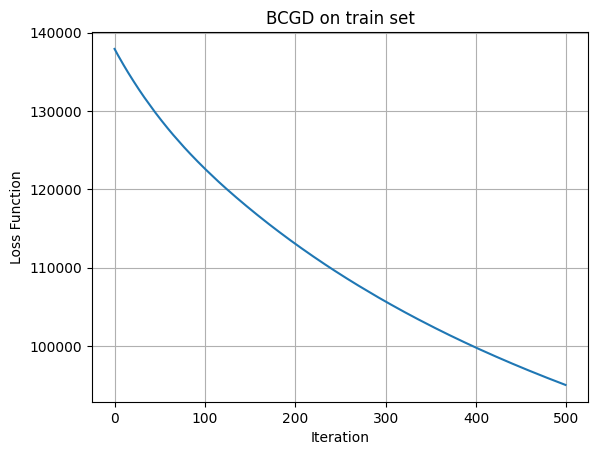

In [76]:
import matplotlib.pyplot as plt
plt.plot(losses_train_BCGD)

# Set labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss Function')
plt.title('BCGD on train set')
plt.grid(True)


# Show the plot
plt.show()

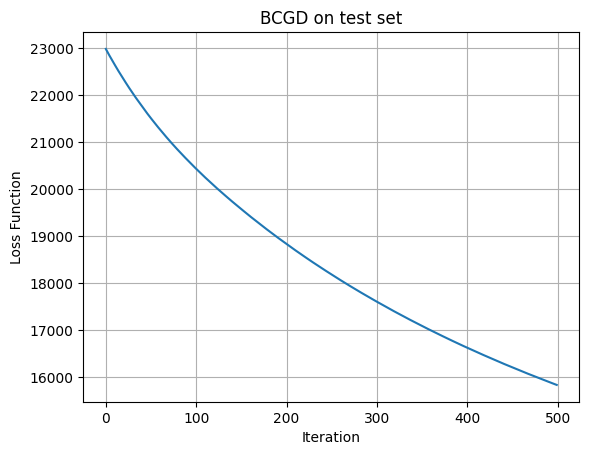

In [77]:
import matplotlib.pyplot as plt
plt.plot(losses_test_BCGD)

# Set labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss Function')
plt.title('BCGD on test set')
plt.grid(True)


# Show the plot
plt.show()

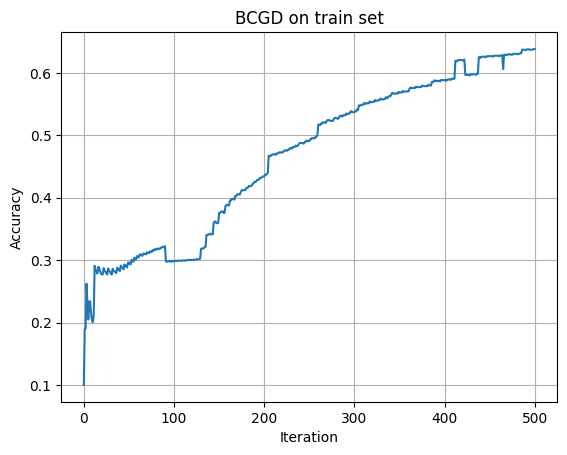

In [78]:
import matplotlib.pyplot as plt
plt.plot(accuracies_train_BCGD)

# Set labels and title
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('BCGD on train set')
plt.grid(True)


# Show the plot
plt.show()

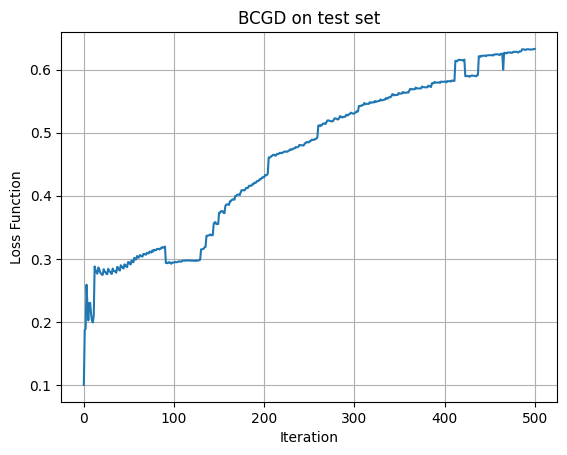

In [80]:
import matplotlib.pyplot as plt
plt.plot(accuracies_test_BCGD)

# Set labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss Function')
plt.title('BCGD on test set')
plt.grid(True)


# Show the plot
plt.show()

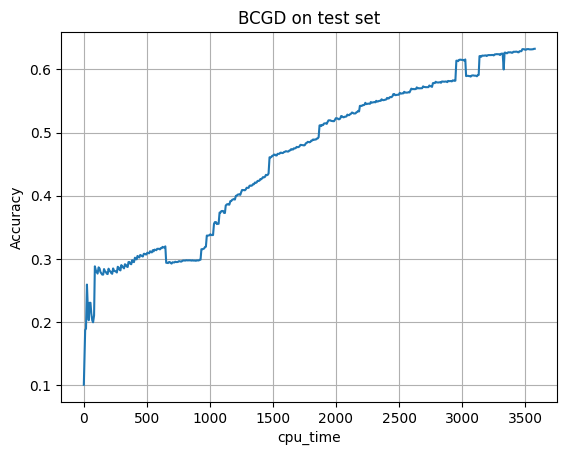

In [81]:
import matplotlib.pyplot as plt
plt.plot(cpu_times, accuracies_test_BCGD)

# Set labels and title
plt.xlabel('cpu_time')
plt.ylabel('Accuracy')
plt.title('BCGD on test set')
plt.grid(True)


# Show the plot
plt.show()